In [1]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [2]:
r = 0.2
N = 110
M = round(Int, N*(1-r))
f = 1-3r
AA = permutedims(ldpc_matrix(N,M,3M,[0,1-f,f],[0, 0, 1]))
src = bitrand(N)
BB, ind = findbasis_slow(BitMatrix(AA));

In [3]:
@time exact_wef(BB, [src]);

  1.993268 seconds (2.81 M allocations: 153.900 MiB, 2.71% gc time, 66.29% compilation time)


In [4]:
# plot_wef(h[1], size=(400,200))

## Vary the rate

In [5]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [74]:
Rs = (1:5) * 1 // 16
nn = 6
navg = 10 * ones(Int, nn)
nmax(R) = (30 / R ÷ 16)
nmaxes(R, nn) = begin
    nm = nmax(R)
    k = max(1, round(Int, nm/nn))
    nm-nn*k+1 <= 0 && (k=1)
    [16*i for i in nm-nn*k+1:k:nm]
end
ns = [nmaxes(r, nn) for r in Rs]
nsources = 50
d = [[fill(NaN, navg[i]) for i in eachindex(ns[a])] for a in eachindex(Rs)]
wef_zero = [[[zeros(Int, ns[a][i]) for _ in 1:navg[i]] for i in eachindex(ns[a])] for a in eachindex(Rs)]
t = fill(NaN, length(ns));

In [75]:
ns

5-element Vector{Vector{Int64}}:
 [16, 96, 176, 256, 336, 416]
 [64, 96, 128, 160, 192, 224]
 [80, 96, 112, 128, 144, 160]
 [32, 48, 64, 80, 96, 112]
 [16, 32, 48, 64, 80, 96]

In [127]:
R = Rs[end]
n = ns[end][end]
 m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
B, indep = findbasis_slow(BitMatrix(H))
rtrue = size(B,2) / size(B,1)
rtrue, float(R)

(0.3125, 0.3125)

In [76]:
@telegram "Exact enumeration-larger sizes" for (i,R) in enumerate(Rs)
    println("Rate $i of ", length(Rs))
    tt = @timed for (a,n) in enumerate(ns[i])
        println("### Size $a of ", length(ns[i]))
        flush(stdout)
        m = round(Int, n*(1-R))
        f3 = 1-3R
        Λ = [0,1-f3,f3]
        K = [0, 0, 1]
        nedges = 3m
        @threads for j in 1:navg[a]  
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
            s = [bitrand(n) for _ in 1:nsources]
            B, indep = findbasis_slow(BitMatrix(H))
            rtrue = size(B,2) / size(B,1)
            if rtrue == R
                h0, h, mins = exact_wef(B, s, showprogress=false)
                wef_zero[i][a][j] = h0
                d[i][a][j] = mean(mins)
            end
        end
    end
    t[i] = tt.time
    d
end

Rate 1 of 5
### Size 1 of 6
### Size 2 of 6
### Size 3 of 6
### Size 4 of 6
### Size 5 of 6
### Size 6 of 6
Rate 2 of 5
### Size 1 of 6
### Size 2 of 6
### Size 3 of 6
### Size 4 of 6
### Size 5 of 6
### Size 6 of 6
Rate 3 of 5
### Size 1 of 6
### Size 2 of 6
### Size 3 of 6
### Size 4 of 6
### Size 5 of 6
### Size 6 of 6
Rate 4 of 5
### Size 1 of 6
### Size 2 of 6
### Size 3 of 6
### Size 4 of 6
### Size 5 of 6
### Size 6 of 6
Rate 5 of 5
### Size 1 of 6
### Size 2 of 6
### Size 3 of 6
### Size 4 of 6
### Size 5 of 6
### Size 6 of 6


In [77]:
[Rs t]

5×2 Matrix{Float64}:
 0.0625   65.2151
 0.125   204.059
 0.1875  784.399
 0.25    160.214
 0.3125  651.689

In [78]:
d_avg = [[mean(filter(!isnan, d[a][i])) for i in eachindex(ns[a])] for a in eachindex(Rs)]
d_std = [[std(filter(!isnan, d[a][i]))/sqrt(length(filter(!isnan, d[a][i]))) for i in eachindex(ns[a])] for a in eachindex(Rs)];

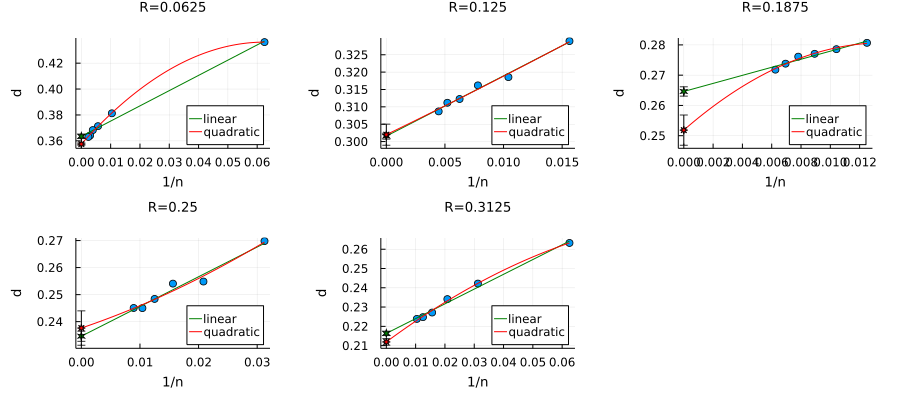

In [79]:
using DataFrames, GLM
d_avg_ = reduce(hcat, d_avg)
d_std_ = reduce(hcat, d_std)
qs = zeros(length(Rs))
qs2 = zeros(length(Rs))
ms = copy(qs)
qs_err = copy(qs)
qs2_err = copy(qs)
plts = Plots.Plot[]
for i in eachindex(Rs)
    x = 1 ./ ns[i]
    x_range = LinRange(0, maximum(x), 100)
    y = d_avg_[:,i]
    data = DataFrame(X=x, Y=y)
    ols = lm(@formula(Y ~ X), data)
    qs[i], ms[i] = coef(ols)
    qs_err[i] = stderror(ols)[1]
    ols2 = lm(@formula(Y ~ X + X^2), data)
    qs2[i], b, c = coef(ols2)
    qs2_err[i] = stderror(ols2)[1]
    plt = scatter(x, y, xlabel="1/n", ylabel="d", label="")
    plot!(plt, x_range, x_range*ms[i] .+ qs[i], title="R=$(float(Rs[i]))", titlefontsize=9, label="linear", 
        legend=:bottomright, c=:green)
    scatter!(plt, [0], [qs[i]], yerr=[qs_err[i]], c=:green, label="", m=:star6)
    plot!(plt, x_range, x_range.^2*c .+ x_range*b .+ qs2[i], title="R=$(float(Rs[i]))", titlefontsize=9, 
        label="quadratic", c=:red)
    scatter!(plt, [0], [qs2[i]], yerr=[qs2_err[i]], c=:red, label="", m=:star8, labelfontsize=9)
    push!(plts, plt)
end
plot(plts..., size=(900,400), margin=5Plots.mm)

In [80]:
# using DelimitedFiles
# open("exact_enum.txt", "w") do io
#    writedlm(io, Rs')
#     writedlm(io, reduce(hcat, d_avg)')
#     writedlm(io, reduce(hcat, d_std)')
#     writedlm(io, )
# end

In [84]:
ns_ = reduce(hcat, ns)

6×5 Matrix{Int64}:
  16   64   80   32  16
  96   96   96   48  32
 176  128  112   64  48
 256  160  128   80  64
 336  192  144   96  80
 416  224  160  112  96

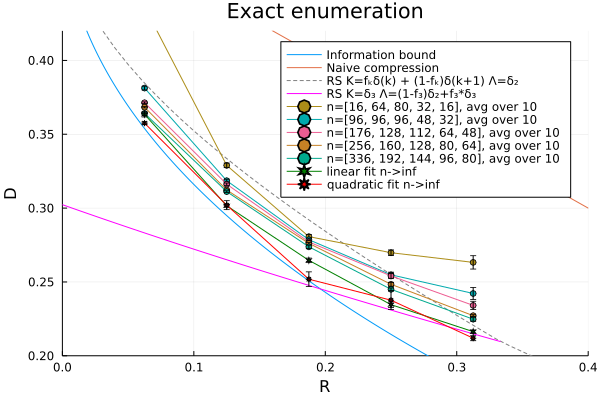

In [120]:
ns_ = reduce(hcat, ns)
pl = plot_rdb(f3=true)
for (j,n) in enumerate(ns)
    plot!(pl, Rs, d_avg_[j,:], yerr=d_std_[j,:], ms=3, label="n=$(ns_[j,:]), avg over $(navg[j])", marker=:o)
end
plot!(pl, title="Exact enumeration")
plot!(pl, Rs, qs, yerr=qs_err, ms=3, label="linear fit n->inf", marker=:star6, c=:green)
plot!(pl, Rs, qs2, yerr=qs2_err, ms=3, label="quadratic fit n->inf", marker=:star8, c=:red)
plot(pl,  xlims=(0, 0.4), ylims=(0.2, 0.42))

Runtime: 0.5 hours


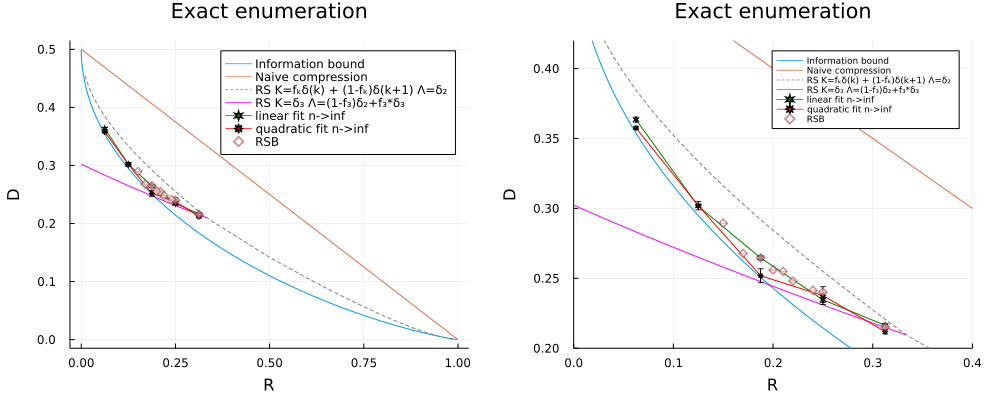

In [90]:
yopt_data = readdlm("yopt_data.txt")
t_hours = sum(t) / 3600
println("Runtime: ", round(t_hours,digits=1), " hours")
# Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = (0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])
# Rs_rsb = [0.25, 0.24, 0.22, 0.21, 0.2]
# y_rsb = vec([1.0 0.8 0.6 0.6 0.5])
# Ds_rsb = vec([0.24011787600556012 0.2414476621129465  0.24807018468086312 0.25495222929686445 0.2559480964548462])
# Ds_rsb_err = vec([0.000159658045833383    0.00017446890849328505  0.00010732745566573257  0.0001310842611345421   0.00027291305140915954])
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:]
M = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
plot!(pl, legendfontsize=6)
scatter!(pl, Rs_rsb, Ds_rsb, yerr=Ds_rsb_err, label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
pl2 = deepcopy(pl)
# plot!(pl2, Rs_rsb_23, Ds_rsb_23, m=:diamond, label="RSB y=0.5")
# scatter!(pl2, [0.24, 0.25], [0.2414, 0.2401], label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
plot!(pl2, xlims=(0, 0.4), ylims=(0.2, 0.42), legendfontsize=6)
# plot!(pl, R_bp_dec, D_bp_dec_avg, m=:x, label="BP+dec")
plot(pl, pl2, size=(1000,400), margin=5Plots.mm, dpi=1000)

In [436]:
savefig("exact_enum.pdf")

## WEF

In [204]:
include("../code/exact_enum.jl")

plot_wef_prob (generic function with 1 method)

In [93]:
correct = [[[!isnan(d[i][j][k]) for k in 1:navg[j]] for j in eachindex(ns[i])] for i in eachindex(Rs)];

WEF wrt the zero codeword


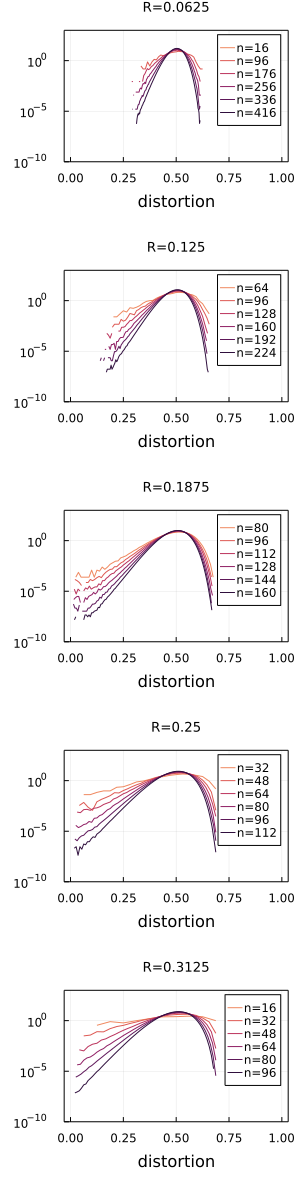

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

In [112]:
using ColorSchemes
cg = cgrad(:matter, length(ns[1])+2, categorical=true)
plts = [Plots.plot() for _ in Rs]
println("WEF wrt the zero codeword")
for (i,R) in enumerate(Rs)
   for (j,n) in enumerate(ns[i])
        maxl = maximum(length, wef_zero[i][j])
        for k in eachindex(wef_zero[i][j])
            append!(wef_zero[i][j][k], zeros(Int, -length(wef_zero[i][j][k])+maxl))
        end
        x = mean([wef_zero[i][j][k] for k in eachindex(wef_zero[i][j]) if correct[i][j][k]])
        st = j==1 ? :scatter : :line
        st = :line
       plot_wef!(plts[i], x,
            plotmin=false, seriestype = st, color=cg[j+2], framestyle=:box, bottom_margin=5Plots.mm,
            label="n=$n", title="R=$(float(R))", yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0) 
    end
end
plot(plts..., size=(300,1200), layout=(5,1), left_margin=5Plots.mm)

In [113]:
savefig("wef_new.pdf");

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

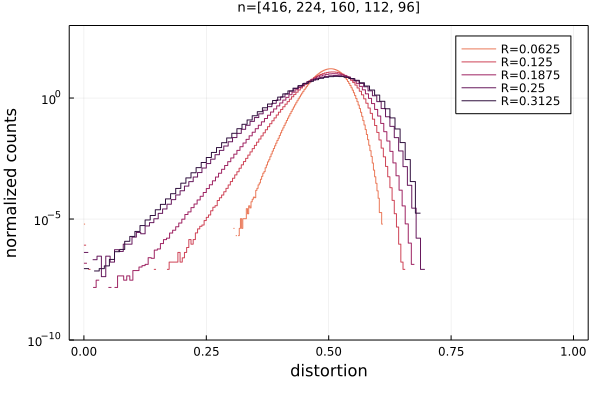

┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95


In [117]:
pp = plot()
cg2 = cgrad(:matter, length(Rs)+2, categorical=true)
for (j,R) in enumerate(Rs)
    x = mean([wef_zero[j][end][k] for k in eachindex(wef_zero[j][end]) if correct[j][j][k]])
   plot_wef!(pp, x,
        plotmin=false, seriestype = :step, color=cg2[j+2], framestyle=:box, bottom_margin=5Plots.mm,
        label="R=$(float(R))", yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0) 
end
plot!(pp, title="n=$([ns[i][end] for i in eachindex(ns)])")

In [60]:
w = wef_zero[end][j][2]
findfirst(!iszero, w[2:end])
sparse(w)

76-element SparseVector{Int64, Int64} with 34 stored entries:
  [1 ]  =  1
  [18]  =  1
  [19]  =  3
  [21]  =  2
  [22]  =  3
  [23]  =  9
  [24]  =  5
  [25]  =  10
  [26]  =  19
  [27]  =  21
        ⋮
  [41]  =  353
  [42]  =  308
  [43]  =  287
  [44]  =  208
  [45]  =  139
  [46]  =  78
  [47]  =  41
  [48]  =  26
  [49]  =  4
  [50]  =  1
  [51]  =  1

In [239]:
j = 4
println("Rate = ", Rs[j])
pl_zero = plot_wef(wef_zero[end][j][2], yaxis=(:log10, (1e-20,1)))
pl_src = plot_wef(wef_src[end][j][2], yaxis=(:log10, (1e-20,1)))
pl4 = plot(pl_zero, pl_src, size=(800,400))

Rate = 1//4


In [240]:
j = 5
println("Rate = ", Rs[j])
pl_zero = plot_wef(wef_zero[end][j][2], yaxis=(:log10, (1e-20,1)))
pl_src = plot_wef(wef_src[end][j][2], yaxis=(:log10, (1e-20,1)))
pl8 = plot(pl_zero, pl_src, size=(800,400))

Rate = 5//16


In [241]:
plot(pl4, pl8, layout=(2,1))

In [44]:
t

3-element Vector{Float64}:
  154.878570836
  101.947241188
 3780.880665511

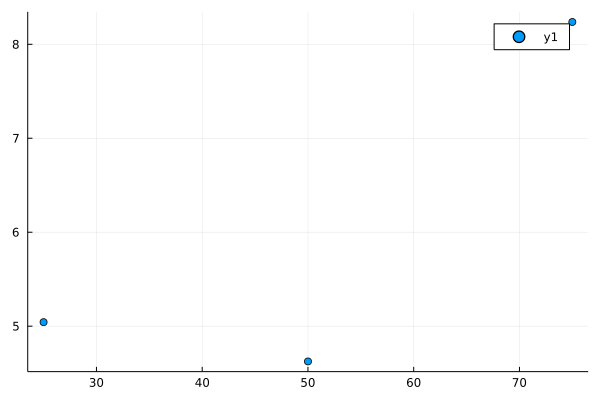

In [25]:
scatter(ns, log.(t))

In [564]:
include("../code/rs.jl")

iter_slow_var (generic function with 1 method)

In [565]:
r = 0.98
α=1-r
k=floor(Int, 2/α)
s=k+1-2/α
K=[fill(0,k-1); s; 1-s]
K .*= K .> 1e-10
K ./ sum(K)
r1,d,p = RS(K, [0,1]; N=200, tol=1e-15, maxiter=10^5)

Pk[ks] = [0.9999999999999147]
Λ[ds] = [1]
ks = [100]
err = 5.551115123125783e-16
iter = 327
Fia = -2.00000000000024
Fi = 1.001626345561623
Fa = 0.0011081204703528677
O = 0.9972655339682639


(0.9799999999999983, 0.0013672330158680523, [3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18  …  3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18, 3.019351708052435e-18], [3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18  …  3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18, 3.0193517080524357e-18])

In [489]:
using Unzip
Rm,Dm=map(big.(0.8:0.01:0.99)) do r
#     @show r
    α=1-r
    k=floor(Int, 2/α)
    s=k+1-2/α
    K=[fill(0,k-1); s; 1-s]
    K ./ sum(K)
    @show K
    r1,d,p = RS(K, [0,1]; N=400, tol=1e-15, maxiter=10^5, T=BigFloat)
    
    @show r r1
    r,d
end |>unzip 

K = BigFloat[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.232595164407830945955825883254338290955991839179852487765929530031150902704666e-31, 0.999999999999999999999999999999876740483559216905404417411674566170904400816082]
Pk[ks] = BigFloat[0.999999999999999999999999999999876740483559216905404417411674566170904400816082]
Λ[ds] = [1]
ks = [10]
err = 9.318716286981354908504931235553351331618015433404245534064948801707235213361275e-16
iter = 336
Fia = -2.000000030248214324193827994597678911398380268252138583949639806659901435031267
Fi = 1.03657450862840028464910090067232209651073690579053797615016804045008640811102
Fa = 0.04677723496836231300514180177186380677909998065685469055679924822855213829614801
O = 0.9166482866514517265395852921534930081085433818047459172426725179812628886240993
r = 0.7999999999999999999999999999999975348096711843381080883482334912930322712298903
r1 = 0.7999999999999999999999999999999753480967118433810808834823349101955992015200825
K = BigFloat[0.0, 0.0, 0.0, 0.0, 0.

Fa = 0.0186003703486268948016216323764895817836881800666885590359868129610777574035895
O = 0.9640418892329979158338863065917100121578172127266930631015997428005132426872596
r = 0.8900000000000000000000000000000374708929979980607570571068509323459094773056677
r1 = 0.8900000000000000000000000000000374708929979980607570571068509323459094773056677
K = BigFloat[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.999999999999999999999999999991618352882026749567500383993866883709301670162214, 8.381647117973250432499616006133116290698329837786034727464569997496153482181173e-30]
Pk[ks] = BigFloat[0.999999999999999999999999999991618352882026749567500383993866883709301670162214]
Λ[ds] = [1]
ks = [20]
err = 9.706526962814120679746669479793163596007947506503410899763599328995441165454279e-16
iter = 332
Fia = -2.000000000000290226807166306815275698009793138238412199654234666917995009498615
Fi = 1.01534717348658124461182511392941588874405780009476039121709

err = 9.512086881348249452053258769307794257077843542254513585703753409197139731757496e-16
iter = 330
Fia = -2.000000000000352353544925950392491977841629271532347871785097708643765059612834
Fi = 1.001626345561735452223898463267929495134742959709004013519676627024447216685976
Fa = 0.0
O = 0.9983736544386169013210274871245624827068863118233438582654210816193178429268581
r = 0.9800000000000000000000000000000774069763248117834060258654683733987866833814451
r1 = 0.9799999999999999999999999999922593023675188216593974134501367809295379260203577
K = BigFloat[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

(BigFloat[0.7999999999999999999999999999999975348096711843381080883482334912930322712298903, 0.8100000000000000000000000000000019721522630525295135293214132069655741830160878, 0.8200000000000000000000000000000064094948549207209189702945929226381160948022853, 0.8300000000000000000000000000000108468374467889123244112677726383106580065884827, 0.8400000000000000000000000000000152841800386571037298522409523539831999183746802, 0.8500000000000000000000000000000197215226305252951352932141320696557418301608777, 0.8600000000000000000000000000000241588652223934865407341873117853282837419470752, 0.8700000000000000000000000000000285962078142616779461751604915010008256537332727, 0.8800000000000000000000000000000330335504061298693516161336712166733675655194702, 0.8900000000000000000000000000000374708929979980607570571068509323459094773056677, 0.9000000000000000000000000000000419082355898662521624980800306480184513890918652, 0.910000000000000000000000000000046345578181734443567939053210363690993300878

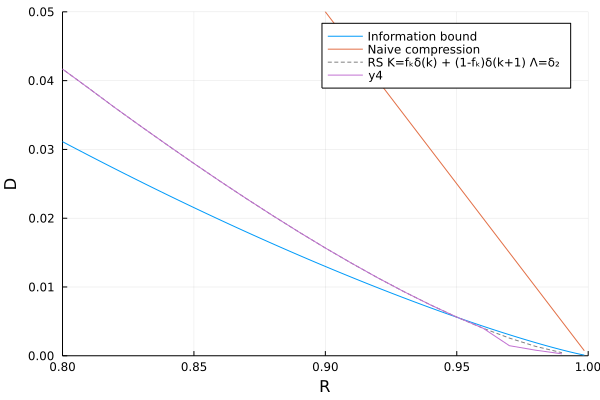

GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory
GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory


In [490]:
pl = plot_rdb()
plot!(Rm, Dm,xlims=(0.8,1), ylims=(0,0.05))

In [566]:
r = big(0.98)
α=1-r
k=floor(Int, 2/α)
s=k+1-2/α
K=[fill(0,k-1); s; 1-s]
# K .*= K .> 1e-10
K ./= sum(K)
r1,d2,q,p = RS(K, [0,1]; N=20, tol=1e-15, maxiter=1000, T=BigFloat, damp=0.95);

Pk[ks] = BigFloat[8.88178419700124443478000113461551487503597125126930663799096231043016481357960285144342764276106244076590211639082571268655962020081001767868737956311099635e-14, 0.999999999999911182158029987555652199988653844851249640287487306933620090376895698351864203971485565723572389375592340978836091742873134403797991899823213126]
Λ[ds] = [1]
ks = [99, 100]
err = 9.93747254281137238217203740089531760317595108040483634350065893798384191967363178569903871757974341768924274027834778434130011256935282897221650378640283606e-16
iter = 673
Fia = -2.00000000000001982209064264843889446572071114371083596394696530312885175689367192985496932493604485617090782809355624544529766595949568341408962254303911329
Fi = 1.00162634556140292077609229403245322328623165301310204425130708796051999173361096132478005590168574045641972601929622998117320131803306344958230639841546942
Fa = 0.0011081204703528521307778948429591121399503572748036714656441211227959582786432647390588644660109234725119135542945888

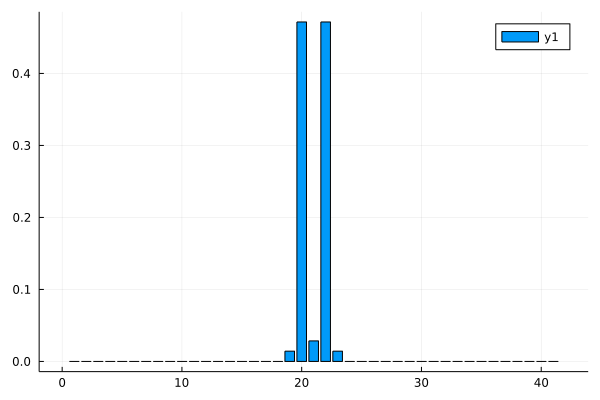

GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory
GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory


In [569]:
bar(p.parent)

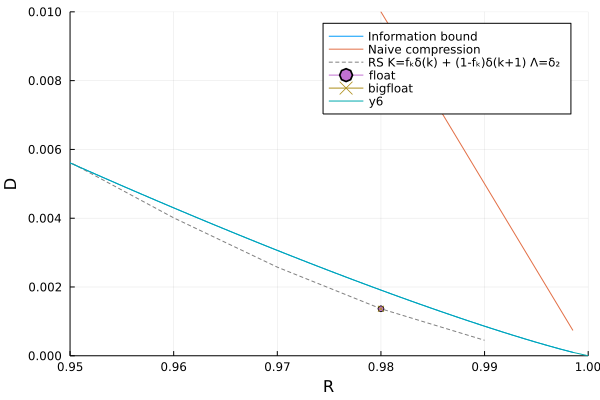

GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory
GKS: file open error (/home/crotti/.julia/artifacts/5213ec57afd921fe10d73686661444c71caa59e3/lib/../fonts/gksfont.dat)
open: No such file or directory


In [567]:
pl = plot_rdb()
plot!([r], [d], m=:o, ms=3, xlims=(0.95,1), ylims=(0,0.01), label="float")
plot!([r], [d2], m=:x, ms=3, xlims=(0.95,1), ylims=(0,0.01), label="bigfloat")
dd = 0:1e-4:0.5
plot!(rdb.(dd), dd)

In [559]:
rdb(d) = 1 + xlogx(d)/log(2) + xlogx(1-d)/log(2)

rdb (generic function with 1 method)

In [560]:
d = 0.002
rdb(d)

0.9791859286644989

In [556]:
import Pkg; Pkg.add("LogExpFunctions")

In [557]:
using LogExpFunctions

In [558]:
?xlogx

search: xlogx xlogy xlog1py



```julia
xlogx(x)

```

Return `x * log(x)` for `x ≥ 0`, handling $x = 0$ by taking the downward limit.

```jldoctest
julia> xlogx(0)
0.0
```


In [ ]:
1 .+ DD.*log2.(DD) + (1 .- DD).*log2.(1 .- DD)

In [506]:
p0 = p[0]

0.0285161845395128284032783671455874271164209497316541333460938470822828576321474055553865019990771420470079051289181412383158460122633380792344921037142911665

In [525]:
sparse(K)

100-element SparseVector{BigFloat, Int64} with 2 stored entries:
  [99 ]  =  8.88178e-14
  [100]  =  1.0

In [526]:
k = 99
q0 = 1 - (1 - p0)^k

0.942967630920974490395090635588234339649586389750882642095897780459639255304552718643956562497669888200350671866232340115844077797141868656595716298392462775

In [522]:
q[0]

0.942967630920973434178570221565919526760599036960818456863728220205740338045449291639209384137084586291568633406047002598342794362451026435146265437741183567

In [509]:
q_pf = copy(q);

In [511]:
q = zero(p)
N = lastindex(p)
for f = 1:N
    v1 = 2p[f]
    v2 = 2*sum(p[f+1:N])
    v = (v1+v2)^k-v2^k
    q[+f] = v/2
    q[-f] = v/2
end
q[0] = 1-(1-p[0])^k
q ./ sum(q)
q[-3:3]

7-element Vector{BigFloat}:
 1.60399180106312446714854743851851463025823201500652283493395189366840962533569269188445011823797511988334995922411317624899806856120953680158092245366991803e-1507
 1.61477366687647772065785454018898566709243680053116022521797674122408216337419889218275872267643092846940353488861535480968998620770884560477192006785972819e-155
 0.0277030117588212064399786364125784938980626767634282186165084917458768216888184641069188764238898504012071228569440924639706152896426550298664567556061430913
 0.944593976482357587120042727174843012203874646473143562766983016508246356622363071786162247152220299197585754286111815072058769420714689940267086488787714204
 0.0277030117588212064399786364125784938980626767634282186165084917458768216888184641069188764238898504012071228569440924639706152896426550298664567556061430913
 1.61477366687647772065785454018898566709243680053116022521797674122408216337419889218275872267643092846940353488861535480968998620770884560477192006785972819e-1

In [512]:
q_pf[-3:3]

7-element Vector{BigFloat}:
 2.39200324046019321338634083553668622886858916325639776844509343561113160558346827659017780853231436122986891038069553124856287962376065635529702069566902898e-17
 2.3949216290157574612352975062774234495778064486060926875344248948171303049309503668271521815662092077939864107380896668833959749439807444003353627427330678e-17
 0.0285161845395128284032783671455874271164209497316541333460938470822828576321474055553865019990771420470079051289181412383158460122633380792344921037142911641
 0.942967630920973434178570221565919526760599036960818456863728220205740338045449291639209384137084586291568633406047002598342794362451026435146265437741183567
 0.0285161845395128284032783671455874271164209497316541333460938470822828576321474055553865019990771420470079051289181412383158460122633380792344921037142911641
 2.3949216290157574612352975062774234495778064486060926875344248948171303049309503668271521815662092077939864107380896668833959749439807444003353627427330678e-17
 2.